In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/IWS/Delivery/")

Mounted at /content/drive


## Load the data 

In this work, we try to use all the H2S data as the labels, the Flow, pH, ORP, temp (15 minutes), rainfall, total solids, ss, BOD5, NH3, Org-N, and SO4 (daily) as training data.
We then open the Excel file directly. It will take a minute or two to open the file.
H2S will be used as the labels.

In [2]:
import pandas as pd
r = 'Model 2 data.xlsx'
H2S = pd.read_excel(r,sheet_name='H2S data')

In [3]:
H2S.head()

,Date,Time,DateTime,H2S_ppm
0,2017-07-14,10:36:55,2017-07-14 10:36:54.720,0
1,2017-07-14,10:51:55,2017-07-14 10:51:55.008,0
2,2017-07-14,11:06:55,2017-07-14 11:06:55.296,0
3,2017-07-14,11:21:55,2017-07-14 11:21:54.720,0
4,2017-07-14,11:36:55,2017-07-14 11:36:55.008,0


Now, we need to deal with the date-time index.
Line 7210 - 7257 are repeating, thus deleted.
Notice that H2S splits into six sessions, due to the inconsistant data collection:

In [4]:
# session one index
index_1 = pd.date_range("2017-7-14 10:36","2017-8-03 11:21", freq="15min")

# session two index
index_2 = pd.date_range("2019-3-07 13:03","2019-3-19 07:33", freq="15min")

# session three index
index_3 = pd.date_range("2019-3-19 09:01","2019-4-03 11:01",freq="15min")

# session four index
index_4 = pd.date_range("2019-4-03 11:20","2019-4-18 07:20",freq="15min")

# session five index
# index_5 = pd.date_range("2019-4-18 07:40","2019-5-01 15:10",freq="15min")
index_5 = pd.date_range("2019-4-18 07:40","2019-4-30 23:55",freq="15min")

# session six index
index_6 = pd.date_range("2019-5-01 00:10","2019-5-16 07:28",freq="15min")

# aggregate two indices into one
index = index_1.append(index_2)
index = index.append(index_3)
index = index.append(index_4)
index = index.append(index_5)
# index = index.append(index_6)

index[-1]

Timestamp('2019-04-30 23:55:00')

This is to assure that the length of index matches the length of H2S data

In [ ]:
# assert(len(index)==len(H2S))

This is to assure that there is no missing data in H2S data

In [5]:
import numpy as np
np.nan in H2S

False

We will now load the flow, ORP, pH, and temp data:

In [6]:
data = pd.read_excel(r,sheet_name='15min data')
data.head()

,date_time,flow_mgd,tunnel_elev_ft,ORP_mV,pH,temp_F,tunnel_pumping,CUP,TUNNEL VOL (MG)
0,2013-03-06 11:45:00,25.6,3.104,22.5,7.3,55.7,NaN,no-cup,0.523
1,2013-03-06 12:00:00,25.6,3.104,22.5,7.3,55.7,NaN,no-cup,0.523
2,2013-03-06 12:15:00,25.6,3.104,22.5,7.3,55.7,NaN,no-cup,0.523
3,2013-03-06 12:30:00,25.6,3.104,22.5,7.3,55.7,NaN,no-cup,0.523
4,2013-03-06 12:45:00,28.1,3.702,27.7,7.3,55.7,NaN,no-cup,0.866


In [7]:
assert(len(index_1) == len(data[152727:154651]))
assert(len(index_2) == len(data[210437:211568]))
assert(len(index_3) == len(data[211569:213018]))
assert(len(index_4) == len(data[213018:214443]))
# assert(len(index_5) == len(data[214444:215723]))

In [8]:
# For now, we have more H2S data than the other data
# So we will truncate the H2S data
# diff = (len(index_6) - len(data[215725:]))
# H2S_truncated = H2S[:-diff]

In [9]:
data[152727:152728]

,date_time,flow_mgd,tunnel_elev_ft,ORP_mV,pH,temp_F,tunnel_pumping,CUP,TUNNEL VOL (MG)
152727,2017-07-14 11:30:00,110.8,86.554,38.5,7.0,69.5,0.0,emptying,70.0


In [10]:
train_data = pd.concat([data[152727:154651],data[210437:211568],data[211569:213018],data[213018:214443],data[214444:215723],data[215725:]])

We now deal with the waste water data (total solids, ss, etc.) and the rainfall data:

In [11]:
#r = 'Water Quality Analysis Data_composite and grab samples.xlsx'
r = 'Water-Quality-Analysis-Data.xlsx'
#r = 'WaterQualityAnalysis.xlsx'
ww_data = pd.read_excel(r,sheet_name='raw_sewage', header = 3, index_col='Date')

#ww_data = ww_data.apply(lambda x: np.nan if x.dtype == str else x)

In [12]:
ww_data

,Temp,pH,ORP,Total Solids,SS,BOD5,NH3,Org-N,TKN,P-TOT,SO4,SO3,VFA,orthoP,SO4-
Date,,,,,,,,,,,,,,,
1997-01-01,59,7.1,-130,875.0,176.0,172,12.64,14.5,27.15,4.78,,,NaN,NaN,NaN
1997-01-02,59,7.4,-133,834.0,152.0,171,11.88,16.0,27.92,4.32,,NaN,NaN,NaN,NaN
1997-01-03,59,7.2,-215,912.0,90.0,128,11.12,15.6,26.73,3.7,,,NaN,NaN,NaN
1997-01-04,57,7.2,-107,1083.0,208.0,167,7.73,18.1,25.83,4.14,,,NaN,NaN,NaN
1997-01-05,57,7.2,-27,994.0,196.0,125,8.90,11.4,20.27,3.46,,,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-27,NaN,NaN,NaN,562.0,59.0,51,8.10,6.4,14.45,1.72,NaN,NaN,NaN,NaN,NaN
2019-08-28,NaN,NaN,NaN,980.0,276.0,160,16.28,16.2,32.47,5.06,NaN,NaN,NaN,NaN,NaN
2019-08-29,NaN,NaN,NaN,890.0,160.0,133,18.43,12.4,30.83,5.11,98,NaN,NaN,NaN,NaN


In [ ]:
# Drop the units
######ww_data.drop(['Date'],inplace=True, axis=1)

In [13]:
# Drop Temp, pH, ORP, SO3 VFA, orthoP SO4-
ww_data.drop(['Temp','pH','ORP','SO3','VFA','orthoP','SO4-'],inplace=True, axis=1)

In [14]:
# Replace white spaces with nan
ww_data['SO4'][ww_data['SO4'] == '     '] = np.nan
ww_data['SO4'][ww_data['SO4'] == '       '] = np.nan

ww_data['SO4'] = ww_data['SO4'].interpolate()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# Fill NA
ww_data.fillna(method='backfill',inplace=True)

In [16]:
# Rainfall data
r = 'Rainfall data.xlsx'
rf = pd.read_excel(r,sheet_name='Daily',index_col='DATE')
rf.drop(['PRCP_KWRP'],inplace=True,axis=1)

In [17]:
# ww_data = ww_data.truncate(before='7/14/2017')
# ww_data.head()

# Now we are have ww data in 2019 from 3/7 to 4/30 (8156)

ww_data = pd.concat([ww_data.iloc[7499:7520],ww_data.iloc[8100:8156]])
rf = pd.concat([rf.iloc[7499:7520],rf.iloc[8100:8156]])

In [18]:
data_holder = {'Total Solids':np.arange(len(index)), 
              'SS':np.arange(len(index)),
              'BOD5':np.arange(len(index)),
              'NH3':np.arange(len(index)),
              'Org-N':np.arange(len(index)),
              'P-TOT':np.arange(len(index)),
              'SO4':np.arange(len(index)),
              'PRCP_NOOA':np.arange(len(index)),
              'TKN':np.arange(len(index))}

####################################################
data2 = pd.DataFrame(data_holder,index=index)
####################################################

attribute_names = ['Total Solids','SS','BOD5','NH3','Org-N','P-TOT','SO4','TKN']
attribute_names2 = ['PRCP_NOOA']
# data2.reindex(attribute_names,axis=1)
data2.head()

,Total Solids,SS,BOD5,NH3,Org-N,P-TOT,SO4,PRCP_NOOA,TKN
2017-07-14 10:36:00,0,0,0,0,0,0,0,0,0
2017-07-14 10:51:00,1,1,1,1,1,1,1,1,1
2017-07-14 11:06:00,2,2,2,2,2,2,2,2,2
2017-07-14 11:21:00,3,3,3,3,3,3,3,3,3
2017-07-14 11:36:00,4,4,4,4,4,4,4,4,4


In [19]:
# Fill in the data
j = 0
for i in range(len(data2)):
    ts = data2.index[i]
    ts2 = ww_data.index[j]
    while True:
        if ts.year == ts2.year and ts.month == ts2.month and ts.day == ts2.day:
            for attr in attribute_names:
                data2[attr][i] = ww_data[attr][j]
            for attr in attribute_names2:
                data2[attr][i] = rf[attr][j]    
            break    
        else:
            j+=1
            ts2 = ww_data.index[j]
data2.head()            

,Total Solids,SS,BOD5,NH3,Org-N,P-TOT,SO4,PRCP_NOOA,TKN
2017-07-14 10:36:00,592,148,81,3,9,2,76,0,12
2017-07-14 10:51:00,592,148,81,3,9,2,76,0,12
2017-07-14 11:06:00,592,148,81,3,9,2,76,0,12
2017-07-14 11:21:00,592,148,81,3,9,2,76,0,12
2017-07-14 11:36:00,592,148,81,3,9,2,76,0,12


In [20]:
H2S_truncated = H2S[:len(index)]

In [21]:
H2S_truncated['H2S_ppm'].describe()

count    7147.000000
mean        0.690639
std         4.994610
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       140.000000
Name: H2S_ppm, dtype: float64

In [22]:
# max is 140
H2S_values = H2S_truncated['H2S_ppm'].values

In [23]:
# Level defines the number of classes
level = 10
Max = 140
levels = Max//level
labels = []
for h2s in H2S_values:
    if h2s == 0:
        labels.append(0)
    elif h2s <= 5:
        labels.append(1)
    elif h2s <= 10:
        labels.append(2)
    else:
        for i in range(2,levels+1):
            if h2s <= i*level:
                labels.append(i+1)
                break;

In [24]:
# # Generate switch
# switch = []
# switch_value = 0
# for value in train_data['tunnel_elev_ft']:
#     if switch_value == 0 and value <= 40:
#         switch.append(switch_value)
#     elif switch_value == 0 and value > 40:
#         switch_value = 1
#         switch.append(switch_value)
#     elif switch_value == 1 and value > 5:
#         switch.append(switch_value)
#     elif value <= 5:
#         switch_value = 0
#         switch.append(switch_value)
        
# assert(len(switch) == len(train_data['tunnel_elev_ft']))

# train_data.head()

# # Tunnel level: previous - current
# tunnel_level = train_data['tunnel_elev_ft'].values[:-1]-train_data['tunnel_elev_ft'].values[1:]

# switch.pop(-1)

train_data_dropped = train_data.drop(train_data.index[-1])

# train_data_dropped['switch'] = switch

#remove date_time
train_data_dropped.drop("date_time",inplace=True,axis=1)

#remove TUNNEL VOL (MG)
train_data_dropped.drop(["TUNNEL VOL (MG)",'CUP'],inplace=True,axis=1)
train_data_dropped.fillna(method='backfill',inplace=True)
train_data = np.hstack((data2.values[:-1],train_data_dropped[:len(index)-1].values))

In [25]:
# Make the labels list into a Series for the histogram
s_labels = pd.Series(labels)

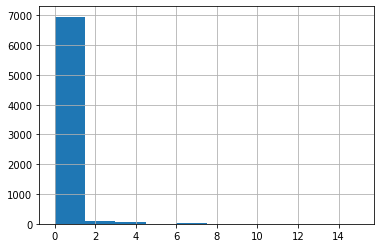

In [26]:
%matplotlib inline
s_labels.hist()

We need random oversampling to solve the imbanlanaced dataset problem

In [27]:
import sys
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [28]:
ros = RandomOverSampler(random_state=0)
#ada = ADASYN(random_state=43, n_neighbors=4)
X_resampled, y_resampled = ros.fit_resample(train_data, s_labels.values[:-1])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After the random oversampling, each class now has same amount of data.
However, if the level is set to be 10, class 11 will have no data:

In [29]:
from collections import Counter
sampling_info = sorted(Counter(y_resampled).items())
print(sampling_info)
y_resampled.size

[(0, 6351), (1, 6351), (2, 6351), (3, 6351), (4, 6351), (5, 6351), (6, 6351), (7, 6351), (8, 6351), (9, 6351), (10, 6351), (11, 6351), (13, 6351), (14, 6351), (15, 6351)]


95265

## Data normalization:

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_resampled)
X_normalized = scaler.transform(X_resampled)
X_normalized.shape

(95265, 15)

## Data sampling (train v.s. test)

In [31]:
jump = sampling_info[0][1] # jump should be the amount of data under each class
split = 0.2
test_amount = int(jump*split)

seed = 43
np.random.seed(seed=seed)
test_indices = []

# if level is 10, we use levels
# otherwise, we may want to use levels+1
for i in range(levels):
    test_indices += list(np.random.choice(np.arange(i*jump,(i+1)*jump),size=test_amount, replace=False))
    
assert(len(test_indices) == (levels)*test_amount)
assert(len(set(test_indices)) == len(test_indices))

In [32]:
train_indices = list(set(np.arange(len(y_resampled))).difference(set(test_indices)))
train_data, train_labels = X_resampled[train_indices], y_resampled[train_indices]
test_data, test_labels = X_resampled[test_indices], y_resampled[test_indices]

In [33]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((77485, 15), (77485,), (17780, 15), (17780,))

## Classification

In [34]:
# Try to remove outliers
# from sklearn.ensemble import IsolationForest
# from imblearn import FunctionSampler

# rng = np.random.RandomState(seed)
# def outlier_rejection(X, y):
#     """This will be our function used to resample our dataset."""
#     model = IsolationForest(max_samples=100,
#                             contamination=0.4,
#                             random_state=rng)
#     model.fit(X)
#     y_pred = model.predict(X)
#     return X[y_pred == 1], y[y_pred == 1]

# reject_sampler = FunctionSampler(func=outlier_rejection)
# train_data, train_labels = reject_sampler.fit_resample(train_data, train_labels)
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


In [35]:
rf = RandomForestClassifier(random_state=seed)
param_grid = [{'n_estimators': [50,100], 'max_features':[4,6,8,10,15], 'bootstrap': [False]}]

In [36]:
grid_search = GridSearchCV(rf, param_grid, cv=10, scoring='accuracy', return_train_score=True, n_jobs=-1)
grid_search.fit(train_data, train_labels)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=43,
                                 

In [37]:
best_rf = grid_search.best_estimator_

print(best_rf)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=43, verbose=0,
                       warm_start=False)


In [38]:
predictions = best_rf.predict(test_data)
print(classification_report(test_labels, predictions))
print("Accuracy: %.2f%%"%((predictions==test_labels).sum()/test_labels.size*100))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1266
           1       0.98      0.98      0.98      1271
           2       0.99      0.97      0.98      1273
           3       0.97      0.96      0.96      1269
           4       0.96      1.00      0.98      1267
           5       1.00      0.86      0.93      1271
           6       1.00      1.00      1.00      1273
           7       0.84      0.74      0.79      1269
           8       1.00      0.77      0.87      1272
           9       0.81      1.00      0.89      1269
          10       1.00      1.00      1.00      1270
          11       0.00      0.00      0.00      1270
          13       0.50      1.00      0.67      1269
          14       0.79      1.00      0.89      1271

    accuracy                           0.88     17780
   macro avg       0.85      0.88      0.85     17780
weighted avg       0.85      0.88      0.85     17780

Accuracy: 87.56%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
# Attribute importance
d = dict(zip(data2.columns.values.tolist()+train_data_dropped.columns.values.tolist(),best_rf.feature_importances_))
import operator
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_d)

[('ORP_mV', 0.24651147598077167), ('flow_mgd', 0.23968013130597826), ('tunnel_elev_ft', 0.19382995924136803), ('pH', 0.0797135374971163), ('temp_F', 0.07835027627843662), ('BOD5', 0.03791432344406833), ('SS', 0.02768583004942271), ('Org-N', 0.023763058858492503), ('Total Solids', 0.02328135575233961), ('TKN', 0.016616009885413032), ('P-TOT', 0.015597462219098053), ('NH3', 0.008957341231939683), ('SO4', 0.007200258939063839), ('tunnel_pumping', 0.000772470167947999), ('PRCP_NOOA', 0.0001265091485433886)]


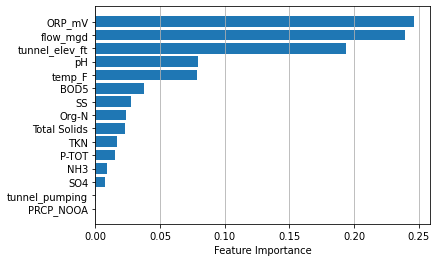

In [40]:
#bar plot for feature importance
import matplotlib.pyplot as plt
scores = []
Vars = []
for k,v in sorted_d[::-1]:
    scores.append(v)
    Vars.append(k)
plt.barh(np.arange(len(scores)), scores,align='center')
plt.yticks(np.arange(len(scores)), Vars)
plt.xlabel('Feature Importance')
plt.grid(True,axis='x')
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


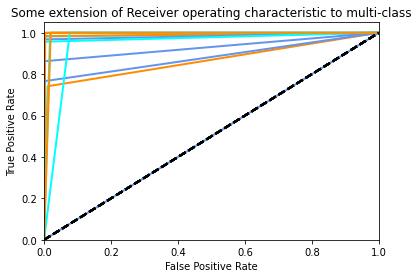

In [41]:
#matplotlib inline
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
labels = [k for k,v in sorted(Counter(y_resampled).items())]
predictions = label_binarize(predictions,classes=labels)

test_labels_copy = label_binarize(test_labels,classes=labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_copy[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
lw=2
for i, color in zip(range(len(labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw)
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
# plt.legend(loc="lower right")
plt.show()    

Warning: SVM runs exetremely slow.
Let's try SVM:

In [42]:
from sklearn.svm import SVC

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                      'C': [1, 10]},
                     {'kernel': ['linear'], 'C': [1, 10]}]

In [43]:
score = 'accuracy'
grid_search = GridSearchCV(SVC(random_state=seed), tuned_parameters, cv=5,
                    scoring= score, n_jobs=-1)

In [ ]:
grid_search.fit(train_data, train_labels)

In [ ]:
best_svm = grid_search.best_estimator_
print(best_svm)

In [ ]:
best_svm = SVC(random_state=seed)
best_svm.fit(train_data, train_labels)
predictions = best_svm.predict(test_data)
print(classification_report(test_labels, predictions))
print("Accuracy: %.2f%%"%((predictions==test_labels).sum()/test_labels.size*100))